###  Implementation of a Low Pass FIR Filter found in SDSoC Design Examples Ported to python
##### Source : https://github.com/hackwa/Pynq

In [13]:
!sudo -H pip install --upgrade 'git+https://github.com/hackwa/Pynq@master#egg=fir'

  Cloning https://github.com/hackwa/Pynq (to master) to /tmp/pip-build-6l0upjkx/fir
  Found existing installation: fir 0.1
    Uninstalling fir-0.1:
      Successfully uninstalled fir-0.1
  Running setup.py install for fir ... - \ | / - \ | / - \ | done
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
# Generate "Noisy" data
import numpy as np
T = 5.0         # seconds
fs = 30.0
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
samples = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

#### Hardware Implementation 

In [15]:
from fir import fir

myDesign = fir()

# Initialize hardware and download bitstream
myDesign.initHw()

# Filter the data here
myDesign.getResponse(list(samples))
#print(myDesign.response)

<IPython.core.display.Javascript object>


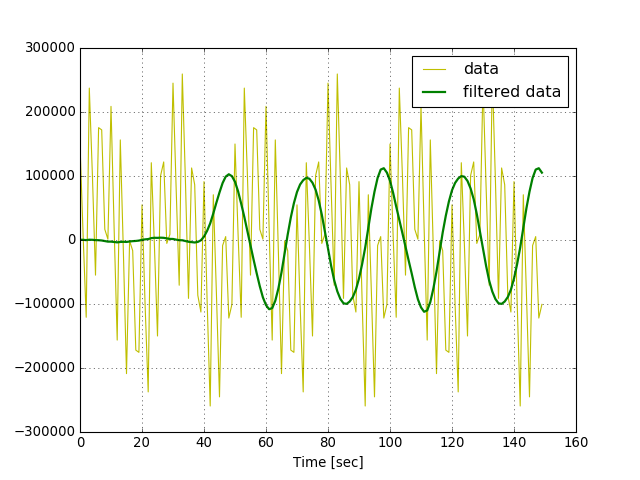

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.subplot(1, 1, 1)
plt.xlabel('Time [sec]')
plt.grid()
plt.plot(samples*100000,'y-',label='data')
plt.plot(myDesign.response,'g-',linewidth=2,label='filtered data')
plt.legend()

#### Software Implementation of filter found at:
http://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
(Benchmarks and Outputs using the same data as that used by hardware design)
Total input samples= 150

<IPython.core.display.Javascript object>


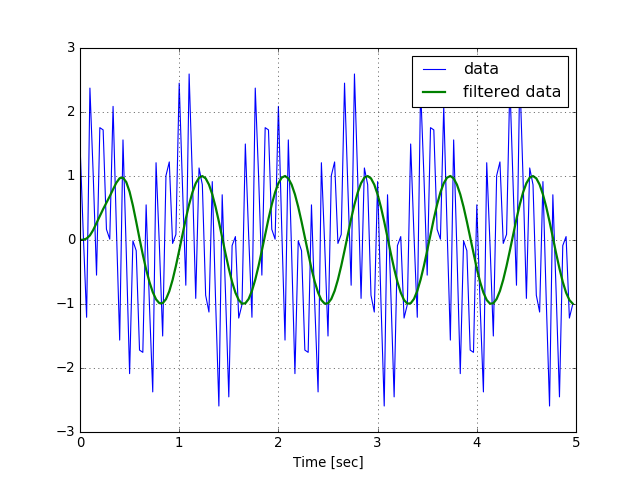

In [19]:
%matplotlib notebook
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 7
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(samples, cutoff, fs, order)

plt.subplot(1, 1, 1)
plt.plot(t, samples, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.35)


#### Benchmarks

In [9]:
number =1000
def hwresp():
    myDesign.getResponse()

def swresp():
    butter_lowpass_filter(([0]), cutoff, fs, order)

import timeit
print("Time taken by hardware to run", number,"times",timeit.timeit(hwresp,number=number))
print("Time taken by software to run", number,"times",timeit.timeit(swresp,number=number))

Time taken by hardware to run 1000 times 2.308368567999878
Time taken by software to run 1000 times 3.48210595799992


<IPython.core.display.Javascript object>


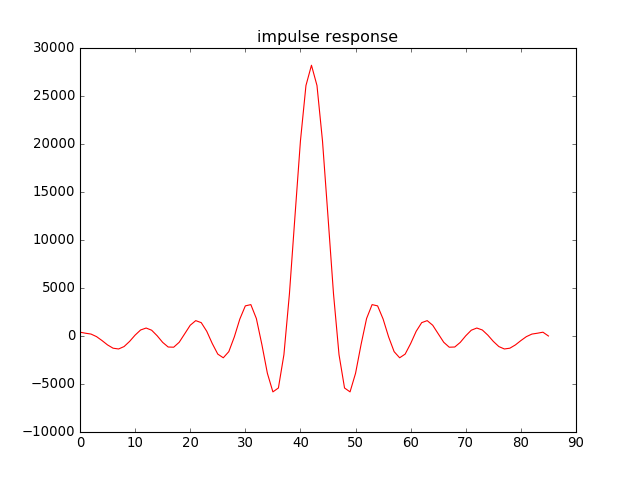

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(myDesign.impulseResponse(),'r')
plt.title('impulse response')

In [12]:
help(myDesign)

Help on fir in module fir.fir object:

class fir(builtins.object)
 |  Class which controls fir filter hardware
 |  
 |  Attributes
 |  ----------
 |  bitfile : str
 |      Absolute path of bitstream file
 |  libfile : str
 |      Absolute path of shared library
 |  response: list
 |      Filter output
 |  nshift_reg : int
 |      Number of shift regs on hardware
 |  overlay : Overlay
 |      Gives access to bitstream overlay
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |  
 |  getResponse(self, datain=[0])
 |      Send input to hardware and get response
 |      
 |      This method takes samples of data and then processes
 |      them on hardware. At the end, it resets the FIR Shift
 |      Registers.
 |      
 |      Parameters
 |      ----------
 |      datain : list
 |          A list containing input samples
 |      
 |      Returns
 |      -------
 |      None
 |          Use response attribute to read output.
 |  
 |  impulseResponse(self)
 |      Get impulse Response 